# CH82 Model

The following tries to reproduce Fig 8 from [Hawkes, Jalali, Colquhoun (1992)](http://dx.doi.org/10.1098/rstb.1992.0116).
First we create the $Q$-matrix for this particular model. Please note that the units are different from other publications.


In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dcprogs.likelihood import QMatrix

tau = 1e-4
qmatrix = QMatrix([[ -3050,        50,  3000,      0,    0 ], 
                   [ 2./3., -1502./3.,     0,    500,    0 ],  
                   [    15,         0, -2065,     50, 2000 ],  
                   [     0,     15000,  4000, -19000,    0 ],  
                   [     0,         0,    10,      0,  -10 ] ], 2)
qmatrix.matrix /= 1000.0

We first reproduce the top tow panels showing $\mathrm{det} W(s)$ for open and shut times.
These quantities can be accessed using `dcprogs.likelihood.DeterminantEq`. The plots are done using a standard plotting function from the `dcprogs.likelihood` package as well.

<IPython.core.display.Javascript object>


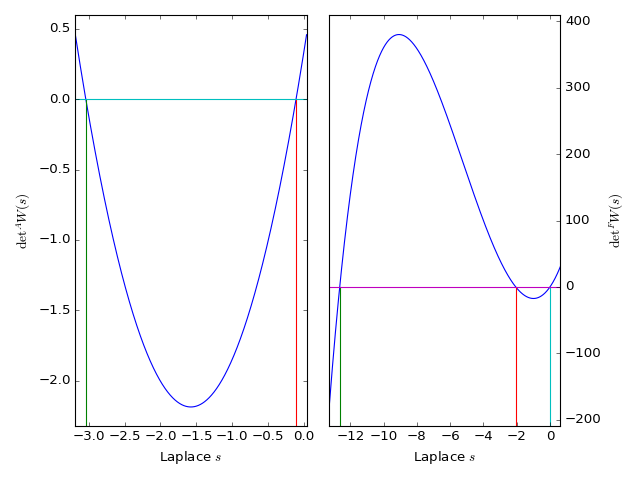

In [4]:
from dcprogs.likelihood import plot_roots, DeterminantEq

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plot_roots(DeterminantEq(qmatrix, 0.2), ax=ax)
ax.set_xlabel('Laplace $s$')
ax.set_ylabel('$\\mathrm{det} ^{A}W(s)$')

ax = fig.add_subplot(1, 2, 2)
plot_roots(DeterminantEq(qmatrix, 0.2).transpose(), ax=ax)
ax.set_xlabel('Laplace $s$')
ax.set_ylabel('$\\mathrm{det} ^{F}W(s)$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.tight_layout()

Then we want to plot the panels c and d showing the excess shut and open-time probability densities$(\tau = 0.2)$. To do this we need to access each exponential that makes up the approximate survivor function. We could use:

In [5]:
from dcprogs.likelihood import ApproxSurvivor
approx = ApproxSurvivor(qmatrix, tau)
components = approx.af_components
print(components[:1])

[(array([[  9.99994874e-01,  -1.96070450e-02],
       [ -2.61427266e-04,   5.12584244e-06]]), -3.050008571211625)]


The list `components` above contain 2-tuples with the weight (as a matrix) and the exponant (or root) for each exponential component in $^{A}R_{\mathrm{approx}}(t)$. We could then create python functions `pdf(t)` for each exponential component, as is done below for the first root:

In [6]:
from dcprogs.likelihood import MissedEventsG

weight, root = components[1]
eG = MissedEventsG(qmatrix, tau)
# Note: the sum below is equivalent to a scalar product with u_F
coefficient = sum(np.dot(eG.initial_occupancies, np.dot(weight, eG.af_factor)))
pdf = lambda t: coefficient * exp((t)*root) 

The initial occupancies, as well as the $Q_{AF}e^{-Q_{FF}\tau}$ factor are obtained directly from the object implementing the weight, root = components[1]
missed event likelihood $^{e}G(t)$.

However, there is a convenience function that does all the above in the package. Since it is generally of little use, it is not currently exported to the `dcprogs.likelihood` namespace. So we create below a plotting function that uses it.

<IPython.core.display.Javascript object>


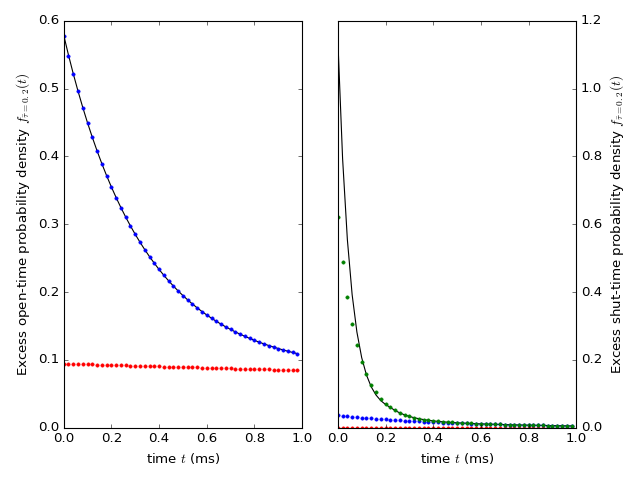

In [7]:
from dcprogs.likelihood._methods import exponential_pdfs

def plot_exponentials(qmatrix, tau, x=None, ax=None, nmax=2, shut=False):
    from dcprogs.likelihood import missed_events_pdf

    if x is None: x = np.arange(0, 5*tau, tau/10)
    pdf = missed_events_pdf(qmatrix, tau, nmax=nmax, shut=shut)
    graphb = [x, pdf(x+tau), '-k']
    functions = exponential_pdfs(qmatrix, tau, shut=shut)
    plots = ['.r', '.b', '.g'] 
    together = None
    for f, p in zip(functions[::-1], plots):
        if together is None: together = f(x+tau)
        else: together = together + f(x+tau)
        graphb.extend([x, together, p])

    if ax is None: plot(*graphb)
    else: ax.plot(*graphb)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('time $t$ (ms)')
ax.set_ylabel('Excess open-time probability density $f_{\\bar{\\tau}=0.2}(t)$')
plot_exponentials(qmatrix, 0.2, shut=False, ax=ax)

ax = fig.add_subplot(1, 2, 2)
plot_exponentials(qmatrix, 0.2, shut=True, ax=ax)
ax.set_xlabel('time $t$ (ms)')
ax.set_ylabel('Excess shut-time probability density $f_{\\bar{\\tau}=0.2}(t)$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
fig.tight_layout()

Finally, we create the last plot (e), and throw in an (f) for good measure.

<IPython.core.display.Javascript object>


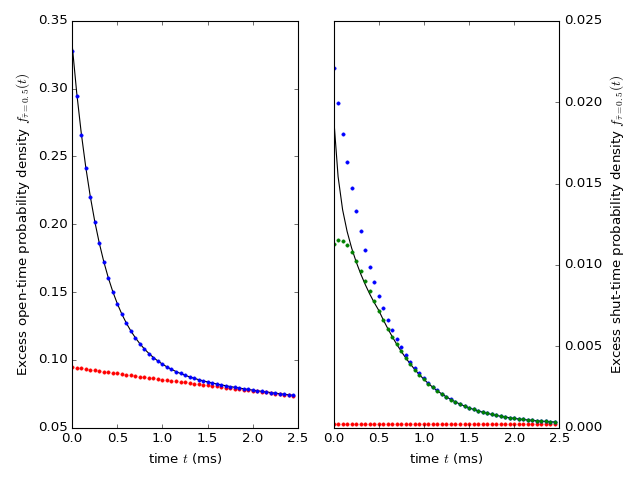

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('time $t$ (ms)')
ax.set_ylabel('Excess open-time probability density $f_{\\bar{\\tau}=0.5}(t)$')
plot_exponentials(qmatrix, 0.5, shut=False, ax=ax)

ax = fig.add_subplot(1, 2, 2)
plot_exponentials(qmatrix, 0.5, shut=True, ax=ax)
ax.set_xlabel('time $t$ (ms)')
ax.set_ylabel('Excess shut-time probability density $f_{\\bar{\\tau}=0.5}(t)$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.tight_layout()

In [9]:
from dcprogs.likelihood import QMatrix, MissedEventsG

tau = 1e-4
qmatrix = QMatrix([[ -3050,        50,  3000,      0,    0 ], 
                   [ 2./3., -1502./3.,     0,    500,    0 ],  
                   [    15,         0, -2065,     50, 2000 ],  
                   [     0,     15000,  4000, -19000,    0 ],  
                   [     0,         0,    10,      0,  -10 ] ], 2)
eG = MissedEventsG(qmatrix, tau, 2, 1e-8, 1e-8)
meG = MissedEventsG(qmatrix, tau)
t = 3.5* tau

print(eG.initial_CHS_occupancies(t) -  meG.initial_CHS_occupancies(t))

[[  4.33883485e-12  -4.33875158e-12]]
